### Timorco
### Exponential Distribution (epidemiology)

## Javi aquí explica lo de la metodologia y ese trip

### First set the number of hosts and number of virus strains
 We defined two hosts:
 1. People from 20 to 40 years old
 2. Babies from 0 to 5 years old, this group is more susceptible to get sick and die
 
 
 We defined two virus strains:
 1. Agressive dissease, simmulating ebola
 2. Soft dissease, simmulating a normal flu

In [1]:
# number of hosts
N_H = 2
# number of virus strains
N_V = 2

 ### Generate probability of mortality for the different type of hosts and strains
 We set the values depending on the host group and virus strain (one strain is more aggressive than the other)


In [2]:
import random
# def no_mortality_prob():
#     return [random.uniform(0,1) for _ in range(N_H)]

# def virus_host_prob():
#     return [[random.uniform(0,1) for _ in range(N_V)] for _ in range(N_H)]

# MU = no_mortality_prob()
MU = [0.90, 0.10] # no mortality probability

# BETA = virus_host_prob()
BETA = [[0.6, 0.3], [0.9, 0.05]] # probability of catching the virus
# print(BETA)
# RO = virus_host_prob()
RO = [[0.75, 0.15], [0.95, 0.5]] # probability of catching the virus again after being already infected

# GAMMA = virus_host_prob()
GAMMA = [[0.90, 0.70], [0.1, 0.4]] # probability of getting better

### Define r_h
R_H is a factor that changes the population's growth rate

In [3]:
R_H = random.uniform(1, 5)
R_H

3.5185554764637796

### Set inital size of population

In [4]:
P_S = 300
P_S

300

### Set Ch

In [5]:
C_H = random.randint(P_S, P_S + 100)
C_H

333

### Define population growth functions
For each of the host we define a different growth function to analize a different behaviour for each of the virus strains

In [6]:
import math

def get_exp_m(m, host_index, virus_index):
    """
    Helper function for computing the exponential of
    probability value
    PARAMS:
    m: type of matrix to compute the exponentiation
    host_index: index of the host group
    virus_index: index of the virus strain
    RETURNS:
    exponentiation of the probability
    """
    return math.exp(-m[host_index][virus_index])

def get_nh(h_index, t):
    """
    Computes the Nh factor
    PARAMS:
    h_index: index of the host group
    t: current timestep
    RETURNS:
    Nh factor
    """
    def get_nh_recur(current_t):
        if current_t == 0:
            return P_S
        else:
            nh_past_times_exp = math.exp(-MU[h_index]) * get_nh_recur(current_t - 1)
            return R_H * nh_past_times_exp * (1 - (nh_past_times_exp / C_H)) + nh_past_times_exp

    if h_index == 0:
        return get_nh_recur(t)
    else:
        return P_S

def get_gh(h_i, t):
    """
    Computes the Gh factor
    PARAMS:
    h_i: index of the host group
    t: current timestep
    RETURNS:
    Gh factor
    """    
    nh = get_nh(h_i, t)
    if h_i == 0:
        return R_H * math.exp(-MU[h_i]) * nh * (1 - (math.exp(-MU[h_i]) * nh)/C_H)
    else:
        return (1 - math.exp(-MU[h_i])) * nh
        
    

In [7]:
PAST_R = [[{} for _ in range(N_V)] for _ in range(N_H)]
PAST_I = [[{} for _ in range(N_V)] for _ in range(N_H)]
PAST_S = [{} for _ in range(N_H)]


def get_s(h_index, t):
    ans = PAST_S[h_index].get(t, None)
    if ans is not None:
        return ans
    if t == 0:
        PAST_S[h_index][t] = 100
        return PAST_S[h_index][t]
    else:
        past = PAST_S[h_index].get(t-1, None)
        if past == None:
            PAST_S[h_index][t-1] = get_s(h_index, t-1)
            past = PAST_S[h_index][t-1]
        PAST_S[h_index][t] = get_gh(h_index, t-1) + math.exp(-MU[h_index]) * math.exp(-sum(BETA[h_index][v_index] * get_i(h_index, v_index, t-1) for v_index in range(N_V))) * past + sum(get_r(h_index, v_index, t-1) * math.exp(-MU[h_index]) * (1 - get_exp_m(RO, h_index, v_index)) for v_index in range(N_V))
        return PAST_S[h_index][t]

def get_i(h_i, v_i, t):
    ans = PAST_I[h_i][v_i].get(t, None)
    if ans is not None:
        return ans
    if t == 0:
        PAST_I[h_i][v_i][t] = 100
        return PAST_I[h_i][v_i][t]
    else:
        past_s = PAST_S[h_i].get(t - 1, None)
        if past_s is None:
            past_s = get_s(h_i, t - 1)
        past_i = PAST_I[h_i][v_i].get(t - 1, None)
        if past_i is None:
            past_i = get_i(h_i, v_i, t - 1)
            PAST_I[h_i][v_i][t - 1] = past_i
        PAST_I[h_i][v_i][t] = past_s * math.exp(-MU[h_i]) * (1 - math.exp(-sum(BETA[h_i][v_index] * get_i(h_i, v_index, t-1) for v_index in range(N_V)))) * ((BETA[h_i][v_i] * past_i)/(sum(BETA[h_i][v_index] * get_i(h_i, v_index, t-1) for v_index in range(N_V)))) + past_i * math.exp(-MU[h_i]) * get_exp_m(GAMMA, h_i, v_i)
        return PAST_I[h_i][v_i][t]


def get_r(h_i, v_i, t):
    ans = PAST_R[h_i][v_i].get(t, None)
    if ans is not None:
        return ans
    if t == 0:
        PAST_R[h_i][v_i][t] = 100
        return PAST_R[h_i][v_i][t]
    else:
        past_r = PAST_R[h_i][v_i].get(t-1, None)
        if past_r is None:
            PAST_R[h_i][v_i][t-1] = get_r(h_i, v_i, t-1)
            past_r = PAST_R[h_i][v_i][t-1]
        past_i = PAST_I[h_i][v_i].get(t-1, None)
        if past_i is None:
            past_i = get_i(h_i, v_i, t-1)
        PAST_R[h_i][v_i][t] = past_r * math.exp(-MU[h_i]) * get_exp_m(RO, h_i, v_i) + past_i * math.exp(-MU[h_i]) * (1 - get_exp_m(GAMMA, h_i, v_i))
        return PAST_R[h_i][v_i][t]

In [8]:
import matplotlib.pyplot as plt
import matplotlib

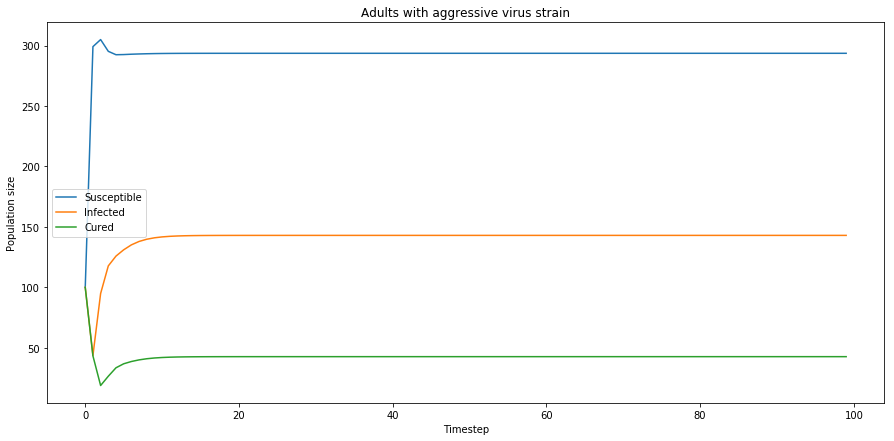

In [9]:
matplotlib.rcParams['figure.figsize'] = [15, 7]
plt.xlabel('Timestep')
plt.ylabel('Population size')
plt.title('Adults with aggressive virus strain')
plt.plot([get_s(0, x) for x in range(100)], label='Susceptible')
plt.plot([get_i(0, 0, x) for x in range(100)], label='Infected')
plt.plot([get_r(0, 0, x) for x in range(100)], label='Cured')
plt.legend()

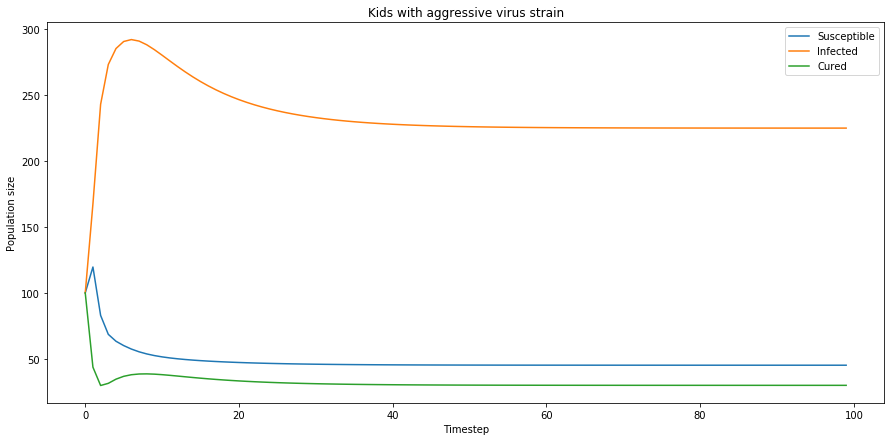

In [10]:
matplotlib.rcParams['figure.figsize'] = [15, 7]
plt.xlabel('Timestep')
plt.ylabel('Population size')
plt.title('Kids with aggressive virus strain')
plt.plot([get_s(1, x) for x in range(100)], label='Susceptible')
plt.plot([get_i(1, 0, x) for x in range(100)], label='Infected')
plt.plot([get_r(1, 0, x) for x in range(100)], label='Cured')
plt.legend()

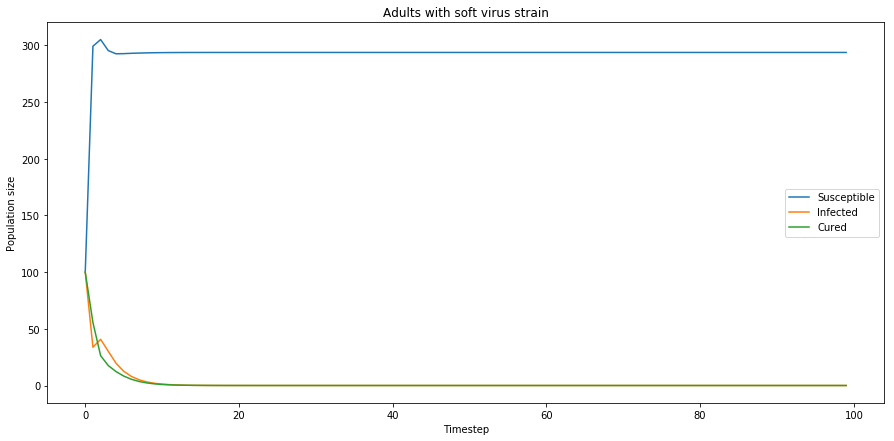

In [11]:
matplotlib.rcParams['figure.figsize'] = [15, 7]
plt.xlabel('Timestep')
plt.ylabel('Population size')
plt.title('Adults with soft virus strain')
plt.plot([get_s(0, x) for x in range(100)], label='Susceptible')
plt.plot([get_i(0, 1, x) for x in range(100)], label='Infected')
plt.plot([get_r(0, 1, x) for x in range(100)], label='Cured')
plt.legend()

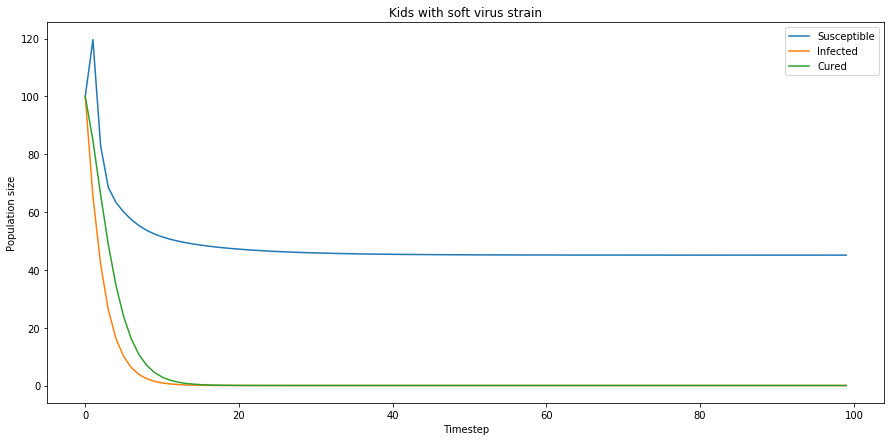

In [12]:
matplotlib.rcParams['figure.figsize'] = [15, 7]
plt.xlabel('Timestep')
plt.ylabel('Population size')
plt.title('Kids with soft virus strain')
plt.plot([get_s(1, x) for x in range(100)], label='Susceptible')
plt.plot([get_i(1, 1, x) for x in range(100)], label='Infected')
plt.plot([get_r(1, 1, x) for x in range(100)], label='Cured')
plt.legend()

### Conclusion

##### pon la conclusión de las graficas